<a href="https://colab.research.google.com/github/taji99/python_basic/blob/master/200726_simple_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# シンプルなRNNの実装
シンプルな再帰型ニューラルネットワーク（RNN）を用いて、時系列データを学習します。

## 訓練用データの作成
RNNに用いる訓練用のデータを作成します。  
サイン関数に乱数でノイズを加えたデータを作成し、過去の時系列データから未来の値を予測できるようにします。  
正解は、入力の時系列を一つ後にずらしたものにします。  

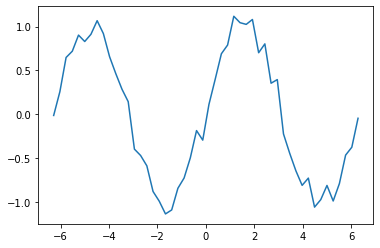

(40, 10, 1)
(40, 10, 1)


In [1]:
import numpy as np
import matplotlib.pyplot as plt

x_data = np.linspace(-2*np.pi, 2*np.pi)  # -2πから2πまで
sin_data = np.sin(x_data)  + 0.1*np.random.randn(len(x_data))  # sin関数に乱数でノイズを加える

plt.plot(x_data, sin_data)
plt.show()

n_rnn = 10  # 時系列の数
n_sample = len(x_data)-n_rnn  # サンプル数
x = np.zeros((n_sample, n_rnn))  # 入力
t = np.zeros((n_sample, n_rnn))  # 正解
for i in range(0, n_sample):
    x[i] = sin_data[i:i+n_rnn]
    t[i] = sin_data[i+1:i+n_rnn+1]  # 時系列を入力よりも一つ後にずらす

x = x.reshape(n_sample, n_rnn, 1)  # KerasにおけるRNNでは、入力を（サンプル数、時系列の数、入力層のニューロン数）にする
print(x.shape)
t = t.reshape(n_sample, n_rnn, 1)  # 今回は入力と同じ形状
print(t.shape)

sin波自体は単純な時系列データですが、これは例えば空気の振動である「音」を表していると考えることもできます。  
上記では、雑音の無いきれいな音にノイズを加えています。  
このようなsin波をニューラルネットワークで学習することができれば、これを例えば音声認識などに応用することも可能です。  
また、ノイズが混ざったsin波から真のsin波を抽出できれば、ノイズの除去が可能です。  
このように、今回扱う対象ははシンプルですが、現実社会で広く応用が可能することができます。

## RNNの構築
Kerasを使ってRNNを構築します。  
今回は、Kerasが持つRNNの中で一番シンプルなSimpleRNN層を使います。

In [2]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

batch_size = 8  # バッチサイズ
n_in = 1  # 入力層のニューロン数
n_mid = 20  # 中間層のニューロン数
n_out = 1  # 出力層のニューロン数

model = Sequential()
# SimpleRNN層の追加。return_sequenceをTrueにすると、時系列の全てのRNN層が出力を返す。
# return_sequenceをTrueをFalseにすると、最後のRNN層のみが出力を返す。
model.add(SimpleRNN(n_mid, input_shape=(n_rnn, n_in), return_sequences=True))
model.add(Dense(n_out, activation="linear"))
model.compile(loss="mean_squared_error", optimizer="sgd")  # 誤差は二乗誤差、最適化アルゴリズムはSGD
print(model.summary())

Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 10, 20)            440       
_________________________________________________________________
dense_1 (Dense)              (None, 10, 1)             21        
Total params: 461
Trainable params: 461
Non-trainable params: 0
_________________________________________________________________
None


## 学習
構築したRNNのモデルを使って、学習を行います。  

In [3]:
history = model.fit(x, t, epochs=20, batch_size=batch_size, validation_split=0.1)

Train on 36 samples, validate on 4 samples
Epoch 1/20
36/36 [==============================] - 0s 11ms/step - loss: 1.0723 - val_loss: 0.4918
Epoch 2/20
36/36 [==============================] - 0s 550us/step - loss: 0.5664 - val_loss: 0.2891
Epoch 3/20
36/36 [==============================] - 0s 548us/step - loss: 0.3869 - val_loss: 0.2218
Epoch 4/20
36/36 [==============================] - 0s 517us/step - loss: 0.3064 - val_loss: 0.1869
Epoch 5/20
36/36 [==============================] - 0s 514us/step - loss: 0.2618 - val_loss: 0.1693
Epoch 6/20
36/36 [==============================] - 0s 492us/step - loss: 0.2320 - val_loss: 0.1565
Epoch 7/20
36/36 [==============================] - 0s 477us/step - loss: 0.2093 - val_loss: 0.1465
Epoch 8/20
36/36 [==============================] - 0s 713us/step - loss: 0.1909 - val_loss: 0.1371
Epoch 9/20
36/36 [==============================] - 0s 614us/step - loss: 0.1755 - val_loss: 0.1270
Epoch 10/20
36/36 [==============================] - 0s 55

## 学習の推移
誤差の推移を確認します。

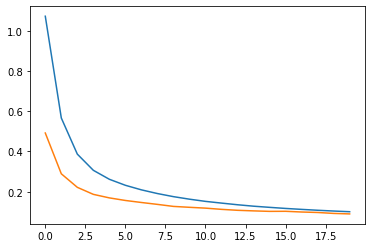

In [4]:
loss = history.history['loss']
vloss = history.history['val_loss']

plt.plot(np.arange(len(loss)), loss)
plt.plot(np.arange(len(vloss)), vloss)
plt.show()

## 学習済みモデルの使用
RNNの学習済みモデルを使って、サイン関数の次の値を予測します。

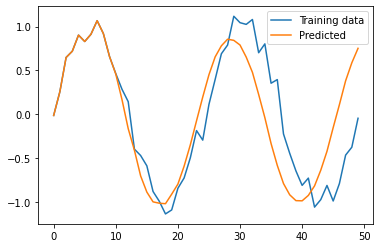

In [5]:
predicted = x[0].reshape(-1)  # 最初の入力。reshape(-1)で一次元のベクトルにする。

for i in range(0, n_sample):
    y = model.predict(predicted[-n_rnn:].reshape(1, n_rnn, 1))  # 直近のデータを使って予測を行う
    predicted = np.append(predicted, y[0][n_rnn-1][0])  # 出力の最後の結果をpredictedに追加する

plt.plot(np.arange(len(sin_data)), sin_data, label="Training data")
plt.plot(np.arange(len(predicted)), predicted, label="Predicted")
plt.legend()
plt.show()

直近の時系列データを使って、次の値を予測できるようになりました。  
今回はサインカーブの予測を行いましたが、同様の技術を例えば価格の予測などに応用することも可能です。